##Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too). 
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.  
<br>
Feel free to adapt this exercise to play with other datasets readily availabe in the Databricks enviornment (they are listed in a cell below). 
#####Getting Started
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with: 
- Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)
- Python Version 3

#####Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)



####Get Data

Here we will pull in some sample data that is already pre-loaded onto all databricks clusters.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

In [2]:
from pyspark.sql.functions import col, when, avg, mean, desc, round
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LocalSparkApp") \
    .master("local[*]") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/29 19:52:14 WARN Utils: Your hostname, zach-kaiser-Alienware-m16-R1-AMD, resolves to a loopback address: 127.0.1.1; using 192.168.12.201 instead (on interface wlp6s0)
25/07/29 19:52:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 19:52:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
columns = ["age", "workclass", "fnlwgt", "education", "education_num", 
           "marital_status", "occupation", "relationship", "race", "sex", 
           "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

df_adult = spark.read.csv("adult.data", header=False, inferSchema=True).toDF(*columns)
df_adult = df_adult.na.drop()
df_adult.createOrReplaceTempView("adult")


In [5]:
# display datasets already in databricks
#display(dbutils.fs.ls("/databricks-datasets"))

#Running notebook locally so I do not have access to databricks functions


Lets take a look at the '**adult**' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. [Here](https://archive.ics.uci.edu/ml/datasets/adult) is the same data in the UCI repository.

_As an aside: [here](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census) this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here)._ 

In [6]:
df_adult.show(5)


+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|       

**Note**: Above  %fs is just some file system cell magic that is specific to databricks. More info [here](https://docs.databricks.com/user-guide/notebooks/index.html#mix-languages).

####Spark SQL
Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called _adult_ and a Spark Dataframe called _df_adult_. 
<br><br>
This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [7]:
spark.sql("SELECT * FROM adult").show()


+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt|    education|education_num|      marital_status|        occupation|  relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0|    Bachelors|         13.0|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0|    Bachelors|         13.0|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|         0.0|         0.0|   

In [8]:
spark.sql("SELECT * FROM adult LIMIT 5").show()


+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|       

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes. 

In [9]:
result = spark.sql(
    '''
    SELECT 
        occupation,
        SUM(1) as n,
        ROUND(AVG(IF(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
        ROUND(AVG(IF(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
        ROUND(AVG(IF(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
        ROUND(AVG(IF(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
        ROUND(AVG(IF(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
    FROM adult 
    GROUP BY 1
    ORDER BY n DESC
    '''
)
result.show()


+------------------+----+------------+----------+------------+--------------+-------------+
|        occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+------------------+----+------------+----------+------------+--------------+-------------+
|    Prof-specialty|4140|        0.53|      0.02|        0.13|          0.02|          0.3|
|      Craft-repair|4099|        0.64|      0.01|        0.11|          0.03|         0.21|
|   Exec-managerial|4066|        0.61|      0.02|        0.15|          0.02|          0.2|
|      Adm-clerical|3770|        0.28|      0.04|        0.22|          0.04|         0.42|
|             Sales|3650|        0.47|      0.03|        0.12|          0.03|         0.36|
|     Other-service|3295|        0.24|      0.05|        0.15|          0.06|          0.5|
| Machine-op-inspct|2002|        0.51|      0.03|        0.14|          0.04|         0.29|
|                 ?|1843|        0.36|      0.08|         0.1|          0.04|   

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.  

In [10]:
result.createOrReplaceTempView("result")


####<span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [11]:
### Question 1.1 Answer ###

spark.sql("""
    SELECT 
        education,
        ROUND(AVG(CASE WHEN TRIM(marital_status) = 'Never-married' THEN 1 ELSE 0 END), 4) AS bachelor_rate
    FROM adult
    GROUP BY education
    ORDER BY bachelor_rate DESC
    LIMIT 1

""").show()


+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|       0.5358|
+---------+-------------+



####Spark DataFrames
Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [12]:
# register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now

In [13]:
# look at df schema
df_adult.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [14]:
# look at the df
display(df_adult)
#df_adult.show(5)

DataFrame[age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

Below we will do a similar calculation to what we did above but using the DataFrames API

In [15]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
|      occupation|divorced_rate|
+----------------+-------------+
|    Adm-clerical|         0.22|
| Priv-house-serv|         0.19|
| Exec-managerial|         0.15|
|    Tech-support|         0.15|
|   Other-service|         0.15|
+----------------+-------------+
only showing top 5 rows


As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.  

####<span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [16]:
### Question 2.1 Answer ###

from pyspark.sql.functions import when, mean, round, desc

df_result = df_adult.select(
    "education",
    when(col("marital_status").rlike("Never-married"), 1).otherwise(0).alias("is_bachelor")
)

df_result = df_result.groupBy("education") \
    .agg(round(mean("is_bachelor"), 4).alias("bachelor_rate")) \
    .orderBy(desc("bachelor_rate"))

df_result.show(1)


+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|       0.5358|
+---------+-------------+
only showing top 1 row


####Explore & Visualize Data
It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df. 

In [17]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

         occupation  plus_50k
0   Exec-managerial  0.484014
1    Prof-specialty  0.449034
2   Protective-serv  0.325116
3      Tech-support  0.304957
4             Sales  0.269315


In [18]:
print(df_pandas.describe())

        plus_50k
count  15.000000
mean    0.197354
std     0.143994
min     0.006711
25%     0.107373
50%     0.134483
75%     0.287136
max     0.484014


In [19]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occupation  15 non-null     object 
 1   plus_50k    15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 372.0+ bytes
None


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want). 

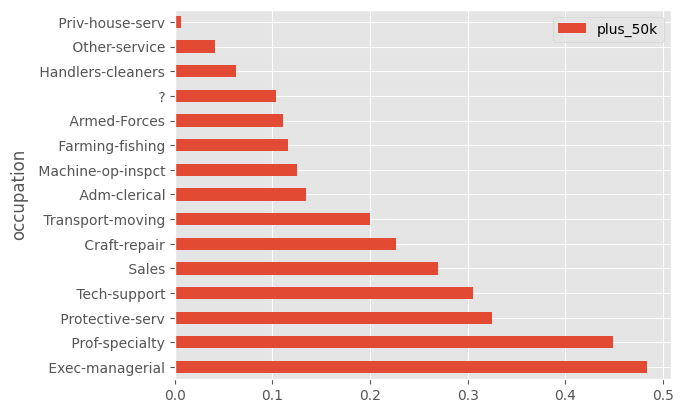

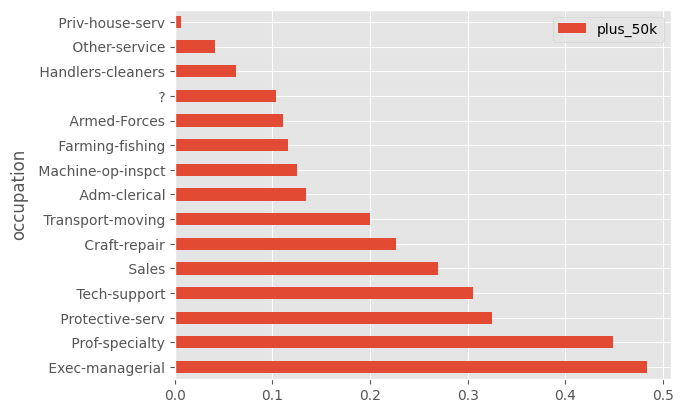

In [20]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.  

In [21]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+-----------------+
|summary|               age|    education_num|
+-------+------------------+-----------------+
|  count|             32561|            32561|
|   mean| 38.58164675532078| 10.0806793403151|
| stddev|13.640432553581356|2.572720332067397|
|    min|                17|              1.0|
|    max|                90|             16.0|
+-------+------------------+-----------------+




### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


In [23]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [24]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [25]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [26]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

25/07/29 19:52:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22832
9729


In [27]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.23988262088297127



####Logistic Regression - Train

In [28]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.3264148967629007


####GBM - Train

####<span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [29]:
### Question 3.1 Answer ###

from pyspark.ml.classification import GBTClassifier

# Create initial LogisticRegression model
gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
gbModel = gb.fit(trainingData)


####Logistic Regression - Predict

In [30]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
display(lrPredictions.select("label", "prediction", "probability"))
#display(lrPredictions)

DataFrame[label: double, prediction: double, probability: vector]


###GBM - Predict

####<span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [31]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)
gbPredictions.select("label", "prediction", "probability").show(5)


display(gbPredictions)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.35655929851434...|
|  0.0|       0.0|[0.75615522160236...|
|  0.0|       0.0|[0.73943054610084...|
|  0.0|       0.0|[0.58853882036455...|
|  0.0|       0.0|[0.56690246697214...|
+-----+----------+--------------------+
only showing top 5 rows


DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string, rawPrediction: vector, probability: vector, prediction: double]


####Logistic Regression - Evaluate

####<span style="color:darkblue">Question 5</span>
1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###

  print("F1 = {}".format(multi_metrics.fMeasure(1.0)))
  print("Precision = {}".format(multi_metrics.precision(1.0)))
  print("Recall = {}".format(multi_metrics.recall(1.0)))
  print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
  print("TPR = {}".format(multi_metrics.truePositiveRate(1.0)))
  
  


####GBM - Evaluate

In [37]:
print_performance_metrics(gbPredictions)

auc = 0.9041170855431602
aupr = 0.7671009111130072
Area under PR = 0.6442504650948611
Area under ROC = 0.7461937549322664
Accuracy = 0.8483914071333127
DenseMatrix([[6960.,  405.],
             [1070., 1294.]])
F1 = 0.6369677578144228
Precision = 0.7616244849911713
Recall = 0.5473773265651438
FPR = 0.054989816700611
TPR = 0.5473773265651438



## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each. 

In [38]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [39]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 


####Logisitic Regression - Param Grid

In [40]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

####GBM - Param Grid

####<span style="color:darkblue">Question 6</span>
1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [41]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
               .addGrid(gb.maxDepth, [2, 5])
               .addGrid(gb.maxIter, [5, 10])
               .addGrid(gb.stepSize, [0.05, 0.1])
               .build())


####Logistic Regression - Perform Cross Validation

In [42]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [43]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5


####GBM - Perform Cross Validation

####<span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [44]:
### Question 7.1 Answer ###

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
gbCvModel = gbCvModel = gbCv.fit(trainingData)

In [45]:
### Question 7.2 Answer ###

# look at best params from the CV
print("Best maxDepth: ", gbCvModel.bestModel._java_obj.getMaxDepth())
print("Best maxIter: ", gbCvModel.bestModel._java_obj.getMaxIter())
print("Best stepSize: ", gbCvModel.bestModel._java_obj.getStepSize())

Best maxDepth:  5
Best maxIter:  10
Best stepSize:  0.1


####Logistic Regression - CV Model Predict

In [46]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

display(lrCvPredictions)

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string, rawPrediction: vector, probability: vector, prediction: double]

####GBM - CV Model Predict

In [47]:
gbCvPredictions = gbCvModel.transform(testData)

display(gbCvPredictions)

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string, rawPrediction: vector, probability: vector, prediction: double]

####Logistic Regression - CV Model Evaluate

In [48]:
print_performance_metrics(lrCvPredictions)

auc = 0.8980093458910213
aupr = 0.7442752297355306
Area under PR = 0.5390761838070597
Area under ROC = 0.8182074291562853
Accuracy = 0.8034741494500977
DenseMatrix([[5815., 1550.],
             [ 362., 2002.]])
F1 = 0.6768086544962814
Precision = 0.5636261261261262
Recall = 0.8468697123519459
FPR = 0.21045485403937542
TPR = 0.8468697123519459


####GBM - CV Model Evaluate

In [49]:
print_performance_metrics(gbCvPredictions)

auc = 0.9041170855431602
aupr = 0.7671009111130072
Area under PR = 0.6442504650948611
Area under ROC = 0.7461937549322664
Accuracy = 0.8483914071333127
DenseMatrix([[6960.,  405.],
             [1070., 1294.]])
F1 = 0.6369677578144228
Precision = 0.7616244849911713
Recall = 0.5473773265651438
FPR = 0.054989816700611
TPR = 0.5473773265651438


####Logistic Regression - Model Explore

In [50]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -5.511258592358523


In [0]:
#lrWeights = lrCvModel.bestModel.coefficients
#rWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
#rWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
#isplay(lrWeightsDF)

#DatBricks features unavailable in local spark

### Feature Importance

####<span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [52]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

# Get metadata from the transformed dataset
attrs = []

metadata = dataset.schema["features"].metadata["ml_attr"]

# Handle numeric and binary attributes
if "attrs" in metadata:
    if "numeric" in metadata["attrs"]:
        attrs += [(attr["idx"], attr["name"]) for attr in metadata["attrs"]["numeric"]]
    if "binary" in metadata["attrs"]:
        attrs += [(attr["idx"], attr["name"]) for attr in metadata["attrs"]["binary"]]

# Sort and extract feature names
attrs = sorted(attrs, key=lambda x: x[0])
feature_names = [name for idx, name in attrs]

# Get model coefficients
coeffs = lrCvModel.bestModel.coefficients.toArray()

# Create DataFrame for inspection
import pandas as pd

lr_feature_importance = pd.DataFrame(
    list(zip(feature_names, coeffs)),
    columns=["feature_name", "feature_coefficient"]
)

# Show sorted by magnitude
print(lr_feature_importance.sort_values(by="feature_coefficient", ascending=False))


                                         feature_name  feature_coefficient
51                         relationshipclassVec_ Wife             1.311065
31          marital_statusclassVec_ Married-AF-spouse             1.148464
18                     educationclassVec_ Prof-school             1.004654
78                      native_countryclassVec_ Japan             1.001967
21                       educationclassVec_ Doctorate             0.944335
..                                                ...                  ...
75         native_countryclassVec_ Dominican-Republic            -0.919848
88                     native_countryclassVec_ Greece            -1.107284
97  native_countryclassVec_ Outlying-US(Guam-USVI-...            -1.373115
80                   native_countryclassVec_ Columbia            -1.464308
7                      workclassclassVec_ Without-pay            -1.990538

[108 rows x 2 columns]


In [53]:
gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

print(gbCvFeatureImportance.sort_values(by=['feature_importance'],ascending =False))

                                      feature_name  feature_importance
25      marital_statusclassVec_ Married-civ-spouse            0.287913
104                                  education_num            0.148962
105                                   capital_gain            0.102239
102                                            age            0.091128
106                                   capital_loss            0.072364
..                                             ...                 ...
47                   relationshipclassVec_ Husband            0.000000
46                occupationclassVec_ Armed-Forces            0.000000
45             occupationclassVec_ Priv-house-serv            0.000000
30   marital_statusclassVec_ Married-spouse-absent            0.000000
23                      educationclassVec_ 1st-4th            0.000000

[108 rows x 2 columns]


####<span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [54]:
### Question 9.1 Answer ###

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)
rfModel = rf.fit(trainingData)

rf_importances = rfModel.featureImportances

rf_feature_importance = pd.DataFrame([(feature_names[i], rf_importances[i]) for i in range(len(feature_names))],
                                     columns=["feature_name", "feature_importance"])
print(rf_feature_importance.sort_values(by="feature_importance", ascending=False))

                                          feature_name  feature_importance
104                                      education_num            0.170209
25          marital_statusclassVec_ Married-civ-spouse            0.168816
105                                       capital_gain            0.125110
47                       relationshipclassVec_ Husband            0.078842
26               marital_statusclassVec_ Never-married            0.045809
..                                                 ...                 ...
93             native_countryclassVec_ Trinadad&Tobago            0.000000
95                    native_countryclassVec_ Thailand            0.000000
96                  native_countryclassVec_ Yugoslavia            0.000000
97   native_countryclassVec_ Outlying-US(Guam-USVI-...            0.000000
98                    native_countryclassVec_ Honduras            0.000000

[108 rows x 2 columns]
